In [1]:
using QuantumToolbox
using CUDA
CUDA.allowscalar(false)
include("/home/alberto/GitHub/DynamicalShiftedFock/CairoMakie.jl")

In [2]:
CairoMakie.set_theme!(merge(theme_dark(), my_theme_Cairo))

In [3]:
CairoMakie.set_theme!(my_theme_Cairo)

## Main figure

For the main figure, we choose the dimer case, and we plot the Wigner function at three different times.

In [100]:
# Parameters

F   = 100
G = 0.0
Δ   = 0.0
γ   = 1
U = 0.3

0.3

In [114]:
N0 = 100

a0 = destroy(N0)
a0 = cu(a0)

H0     = Δ*a0'*a0 + U*(a0^2)'*a0^2 + + F*(a0+a0') + G*(a0^2 + (a0^2)')
c_ops0 = [√γ*a0]

ψ0 = fock(N0, 0)
ψ0 = cu(ψ0)

tlist = range(0, 10/γ, 1000)
# tlist_save = range(tlist[1], tlist[end], 10)
tlist_save = [tlist[1], 0.95, tlist[end]]

sol = mesolve(H0, ψ0, tlist, c_ops0, e_ops=[a0'*a0, a0], saveat=tlist_save);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)


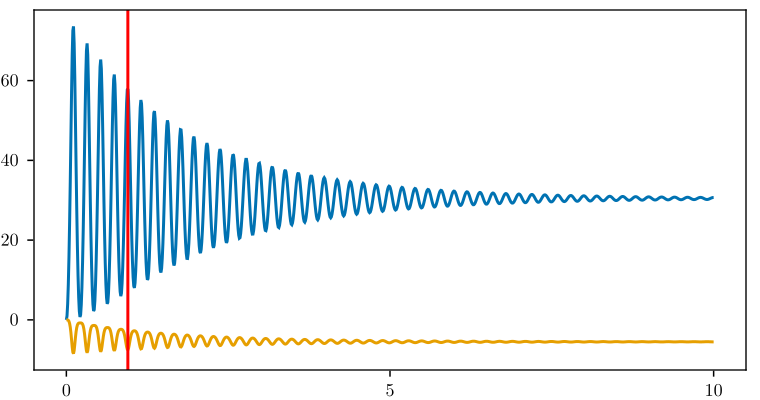

In [115]:
fig = Figure()
ax = Axis(fig[1, 1])

lines!(ax, tlist, real.(sol.expect[1, :]))
lines!(ax, tlist, real.(sol.expect[2, :]))
vlines!(ax, [0.95], color=:red)

fig

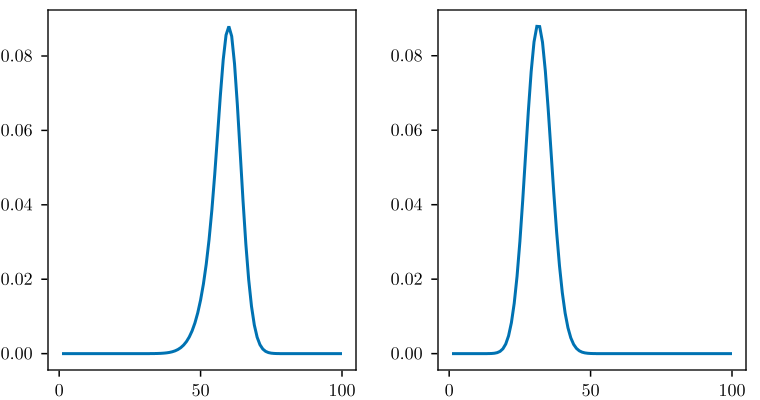

In [116]:
fig = Figure()
ax1 = Axis(fig[1, 1])
ax2 = Axis(fig[1, 2])

i = 2
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
lines!(ax1, 1:N0, real.(diag(ρt.data)))

i = 3
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
lines!(ax2, 1:N0, real.(diag(ρt.data)))

fig

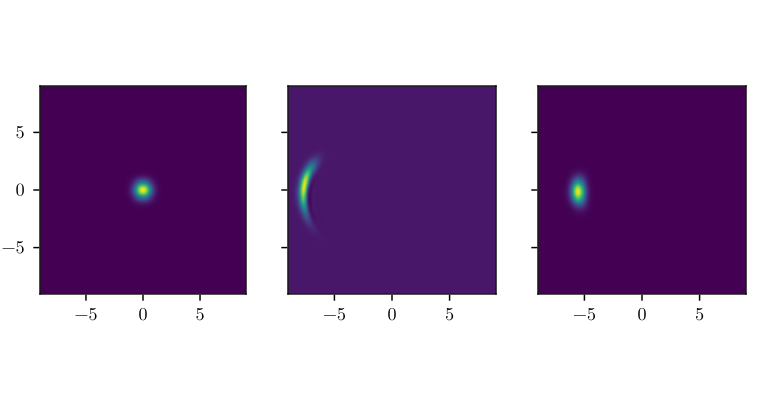

In [117]:
xvec = range(-9, 9, 300)
yvec = range(-9, 9, 300)
xvec_gpu = CuArray(collect(xvec))
yvec_gpu = CuArray(collect(yvec))

fig = Figure()
ax1 = Axis(fig[1, 1])
ax2 = Axis(fig[1, 2])
ax3 = Axis(fig[1, 3])


i = 1
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
wig = wigner(ρt, xvec_gpu, yvec_gpu, g=2) |> Array
heatmap!(ax1, xvec, yvec, wig', rasterize=true)

i = 2
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
wig = wigner(ρt, xvec_gpu, yvec_gpu, g=2) |> Array
heatmap!(ax2, xvec, yvec, wig', rasterize=true)

i = 3
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
wig = wigner(ρt, xvec_gpu, yvec_gpu, g=2) |> Array
heatmap!(ax3, xvec, yvec, wig', rasterize=true)


linkyaxes!(ax1, ax2, ax3)
ax2.yticklabelsvisible = false
ax3.yticklabelsvisible = false

rowsize!(fig.layout, 1, Aspect(1, 1))

fig

In [118]:
i = 2
ρt = Qobj(Array(sol.states[i].data), dims=sol.states[i].dims)
wig = wigner(ρt, xvec_gpu, yvec_gpu, g=2) |> Array
minimum(wig), maximum(wig)

(-0.026580725489642392, 0.4284641524135094)

-3.788782315531355 + 2.0149911437735164im


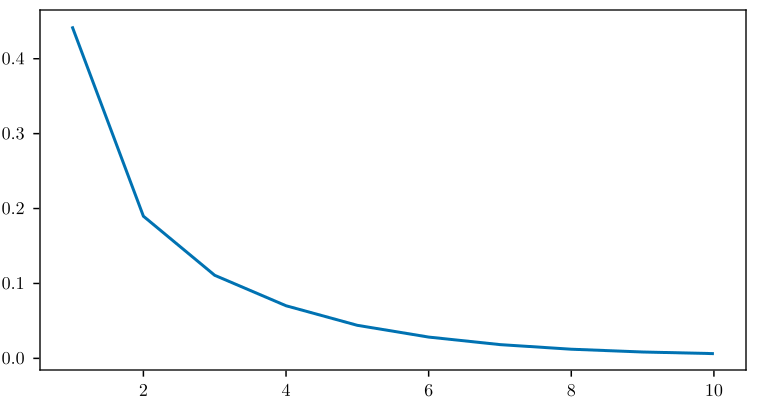

In [83]:
α, δψ = get_coherence(ρt)

println(α)

lines(1:10, real.(diag(δψ))[1:10])

In [141]:
function std(vector)
    n = length(vector)
    fock_n = collect(0:n-1)
    mean_val = dot(vector, fock_n)
    sum_squares = sum(i-> vector[i] * (fock_n[i] - mean_val)^2, 1:n)
    std_dev = sqrt(sum_squares)
    return std_dev
end

std (generic function with 1 method)

In [120]:
vector = abs2.(ψ.data)
n = length(vector)
fock_n = collect(0:n-1)
mean_val = dot(vector, fock_n)

3.9999999999999876

In [148]:
ψ = coherent(300, 4.3)
std(abs2.(ψ.data))

4.3

In [24]:
import QuantumCumulants
using ModelingToolkit

In [42]:
# Define hilbert space
h = QuantumCumulants.FockSpace(:cavity1)

# Define the fundamental operators
QuantumCumulants.@qnumbers a₁::QuantumCumulants.Destroy(h)

QuantumCumulants.@cnumbers Δ₂ F₂ U₂ γ₂ G₂

# Hamiltonian
H₂ = Δ₂*a₁'*a₁ + U₂*(a₁^2)'*a₁^2 + F₂*(a₁ + a₁') + G₂*((a₁^2)' + (a₁^2))

# Collapse operators
Jumps₂ = [a₁]
rates₂ = [γ₂]

# Derive a set of equations
ops = [a₁'*a₁, a₁]
eqs = QuantumCumulants.meanfield(ops,H₂,Jumps₂;rates=rates₂,order=2)

# Expand the above equations to second order
eqs_expanded = QuantumCumulants.complete(eqs);

display(eqs_expanded)

# Generate an ODESystem
@named sys = ODESystem(eqs_expanded);

∂ₜ(⟨a₁′*a₁⟩) = (0 + 1im)*F₂*⟨a₁⟩ + (0 - 1im)*F₂*⟨a₁′⟩ + (0 + 2im)*G₂*⟨a₁*a₁⟩ + (0 - 2im)*G₂*⟨a₁′*a₁′⟩ - ⟨a₁′*a₁⟩*γ₂
∂ₜ(⟨a₁⟩) = (0 - 1im)*F₂ + (0 - 2im)*G₂*⟨a₁′⟩ + (0 - 1im)*⟨a₁⟩*Δ₂ - 0.5⟨a₁⟩*γ₂ + (0 - 2im)*U₂*(2⟨a₁′*a₁⟩*⟨a₁⟩ + ⟨a₁′⟩*⟨a₁*a₁⟩ - 2(⟨a₁⟩^2)*⟨a₁′⟩)
∂ₜ(⟨a₁*a₁⟩) = (0 - 2im)*G₂ + (0 - 2im)*F₂*⟨a₁⟩ + (0 - 4im)*G₂*⟨a₁′*a₁⟩ + (0 - 2im)*U₂*⟨a₁*a₁⟩ + (0 - 2im)*⟨a₁*a₁⟩*Δ₂ - ⟨a₁*a₁⟩*γ₂ + (0 - 4im)*U₂*(3⟨a₁′*a₁⟩*⟨a₁*a₁⟩ - 6⟨a₁′*a₁⟩*(⟨a₁⟩^2) - 6⟨a₁⟩*⟨a₁′⟩*⟨a₁*a₁⟩ + 6(⟨a₁⟩^3)*⟨a₁′⟩ + (3⟨a₁⟩*⟨a₁*a₁⟩ - 2(⟨a₁⟩^3))*⟨a₁′⟩ + 3⟨a₁⟩*(2⟨a₁′*a₁⟩*⟨a₁⟩ + ⟨a₁′⟩*⟨a₁*a₁⟩ - 2(⟨a₁⟩^2)*⟨a₁′⟩))


In [43]:
# Solve the system using the OrdinaryDiffEq package
u0 = zeros(ComplexF64, length(eqs_expanded))

p = (Δ₂, F₂, U₂, γ₂, G₂)
p0 = p .=> (Δ, F, U, γ, G)
prob = ODEProblem(sys, u0, (tlist[1],tlist[end]), p0, saveat=tlist, abstol=sol.abstol, reltol=sol.reltol)
sol_qc = solve(prob, Tsit5());

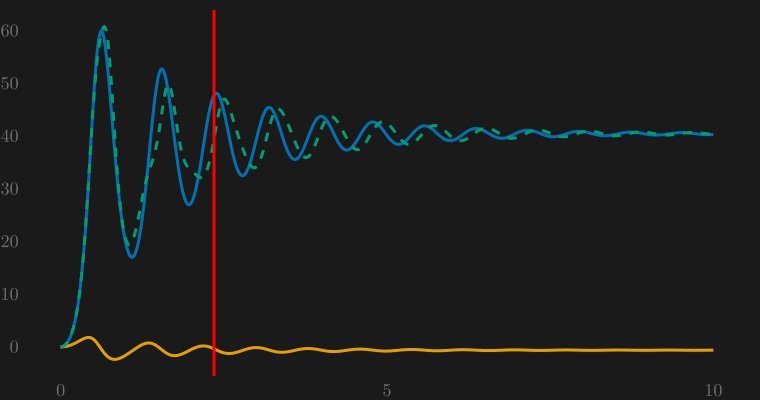

In [44]:
fig = Figure()
ax = Axis(fig[1, 1])

lines!(ax, tlist, real.(sol.expect[1, :]))
lines!(ax, tlist, real.(sol.expect[2, :]))
lines!(ax, tlist, real.(sol_qc[a₁'*a₁]), linestyle=:dash)
# lines!(ax, tlist, abs2.(sol_qc[a₁]), linestyle=:dash)
# lines!(ax, tlist, abs2.(sol_qc[a₂]), linestyle=:dash)
vlines!(ax, [2.35], color=:red)

fig

In [2]:
N_full = 40

Δ = 0.1
U = 0.01
F = 2
γ = 1

a_full = destroy(N_full)

H_full = Δ * a_full' * a_full + F * (a_full' + a_full) + U * (a_full^2)' * a_full^2
c_ops_full = [sqrt(γ) * a_full]
e_ops_full = [a_full' * a_full]

L_full = liouvillian(H_full, c_ops_full)

Quantum Object:   type=SuperOperator   dims=[40]   size=(1600, 1600)
1600×1600 SparseMatrixCSC{ComplexF64, Int64} with 9360 stored entries:
⎡⢿⣿⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠙⢿⣿⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠙⢿⣿⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠙⢿⣿⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣄⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣄⡀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣄⡀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⎦

In [4]:
tlist = range(0, 10, 100)
ψ0_full = fock(N_full, 0)

sol_full = mesolve(H_full, ψ0_full, tlist, c_ops_full, e_ops=e_ops_full);

In [5]:
N = 3
a = destroy(N)
function H_dsf(op_l, p)
    Δ = p.Δ
    U = p.U
    F = p.F
    γ = p.γ
    a = op_l[1]

    return Δ * a' * a + F * (a' + a) + U * (a^2)' * a^2
end

function c_ops_dsf(op_l, p)
    γ = p.γ
    a = op_l[1]

    return [sqrt(γ) * a]
end

function e_ops_dsf(op_l, p)
    a = op_l[1]

    return [a' * a]
end

op_l = [a]
α0_l = [0.0]
dsf_params = (Δ=Δ, U = U, F=F, γ=γ)

(Δ = 0.1, U = 0.01, F = 2, γ = 1)

In [6]:
ψ0 = fock(N, 0)

sol = dsf_mesolve(H_dsf, ψ0, tlist, c_ops_dsf, op_l, α0_l, dsf_params, e_ops=e_ops_dsf);

Progress: [                              ]   1.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 04m 57s)

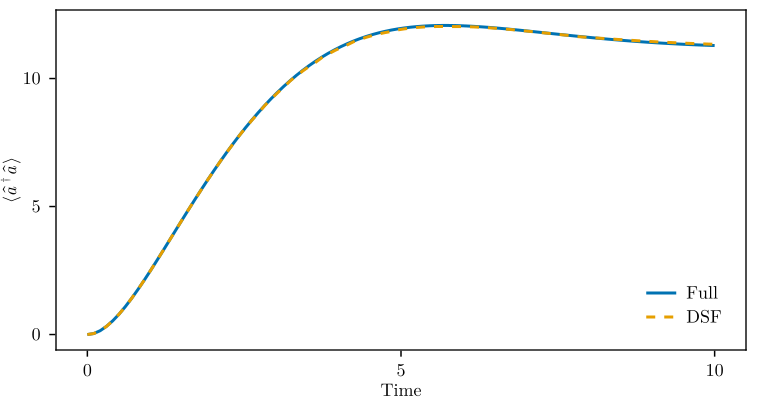

In [7]:
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="Time", ylabel=L"\langle \hat{a}^\dagger \hat{a} \rangle")

lines!(ax, tlist, real.(sol_full.expect[1,:]), label="Full")
lines!(ax, tlist, real.(sol.expect[1,:]), linestyle=:dash, label="DSF")

axislegend(ax, position=:rb)

fig